# Benchmarking Hallucination Detection Methods

In this notebook, we will benchmark hallucination detection methods on subsets of the HaluEval dataset.

Please see our related results paper at [link todo]


## Setup

The two main requirements to replicate are an OPENAI_API_KEY and a TLM_API_KEY.

You can get an OPENAI_API_KEY by signing up for OpenAI at https://platform.openai.com/signup.

You can try TLM for free at https://cleanlab.ai/tlm/




In [ ]:
%pip install datasets --quiet # for importing from huggingface and ragasr
%pip install ragas=="v0.1.16" --quiet # metrics: Faithfulness, etc. Version 0.1.16 is required for HHEM to work
%pip install cleanlab_studio --quiet # metrics: TLM
%pip install deepeval --quiet # metrics: G-Eval

In [2]:
import os
REQUIRED_CREDS = [
    "OPENAI_API_KEY",  # https://platform.openai.com/
    "TLM_API_KEY",  # https://app.cleanlab.ai/tlm
    ]


# Try/except in case you're using google colab for creds
try:
  from google.colab import userdata
  for cred in REQUIRED_CREDS:
    os.environ[cred] = userdata.get(cred)
except ImportError:
  pass

# Also support dotenv, if preferred
try:
  from dotenv import load_dotenv
  load_dotenv()
except ImportError:
  pass

for cred in REQUIRED_CREDS:
    assert cred in os.environ, f"{cred} not found in environment variables. Please set it before proceeding."

In [3]:
from datasets import load_dataset

ds = load_dataset("PatronusAI/HaluBench")

In [4]:
data = ds["test"].to_pandas()

We see the dataset is formatted with context as "passage", question, answer, a label as "FAIL" (Hallucination) or "PASS" (Truthful) and the source dataset:

In [5]:
data.head()

,id,passage,question,answer,label,source_ds
0,d3fb4c3c-d21b-480a-baa0-98d6d0d17c1d,Hoping to rebound from the road loss to the Ch...,Which team scored the longest field goal kick ...,"['Rams', 'second', 'Marc Bulger', 'Kevin Curtis']",FAIL,DROP
1,8603663e-c53b-46db-a482-a867f12ff3b4,"As of the census of 2000, there were 218,590 p...",How many percent were not Irish?,87.1,FAIL,DROP
2,c63a73e5-2c91-489b-bd24-af150ddfa82c,Hoping to rebound from the road loss to the Ch...,How many yards was the second longest field go...,42,FAIL,DROP
3,52db14ed-5426-46ec-b0ae-4ef843b2d692,Hoping to rebound from their tough overtime ro...,How long was the last touchdown?,18-yard,FAIL,DROP
4,31b36417-aad1-412c-b0e5-9c1faaed233f,"As of the census of 2000, there were 218,590 p...",How many in percent from the census weren't Ir...,87.1,FAIL,DROP


In [6]:
data.source_ds.value_counts()

source_ds
halueval        10000
DROP             1000
pubmedQA         1000
FinanceBench     1000
covidQA          1000
RAGTruth          900
Name: count, dtype: int64

We won't use all of these datasets in our benchmarks due to quality issues in the underlying labels - read the blog post for more details!

## Instantiating our hallucination metrics

We'll instantiate a variety of commonly-used and cutting-edge hallucination metrics to evaluate the performance of our hallucination detection models. 

These metrics include:


### Cleanlab's Trustworthy Language Model (TLM)



In [7]:
import os
from cleanlab_studio import Studio

studio = Studio(os.environ["TLM_API_KEY"])
tlm = studio.TLM()

Since `tlm.get_trustworthy_score` takes `prompt` and `response`, we'll turn the `context` and `question` into a single prompt:

In [8]:
data["context_and_question_as_prompt"] = data.apply(
    lambda row: f"Answer the QUESTION using information **only** from CONTEXT:\n{row['passage']}\nQUESTION:\n{row['question']}",
    axis=1
)

## RAGAS and RAGAS++ instantiation

We use both the default instantiation of RAGAS, as well as some improvements we've anecdotally found to be useful. We'll call our improved version `RAGAS++`

For our improved RAGAS++ version, we used `gpt-4o-mini` instead of the default `gpt-3.5-turbo-16k` for generation and `gpt-4` for the critic LLM. In addition, we added a full stop character (`.`) to the end of each answer if not already present, and observed that this lowered the error rate of RAGAS code, likely due to its sentence parsing logic that uses the full stop character. To swap the model, we follow the [official RAGAS documentation](https://docs.ragas.io/en/v0.0.22/howtos/customisations/llms.html#evaluating-with-gpt4).

In [9]:
from datasets import Dataset
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
)

from ragas import evaluate

Note that LangChain complains that the ChatOpenAI class is deprecated, but we'll still use this method because its the official RAGAS instructions, and it runs succuesfully.

In [10]:
from langchain.chat_models import ChatOpenAI

gpt4o_mini = ChatOpenAI(model_name="gpt-4o-mini")

/Users/nelson/.local/share/virtualenvs/sandbox-KzA884qM/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [11]:
# Add full stop character . if not present for improved RAGAS
data["answer_ending_in_period"] = data["answer"].apply(lambda text: text if text.endswith('.') else text + '.')

For faithfulness, we also use HHEM, an open-source hallucination detection model by Vectara. Running HHEM locally is GPU-intensive, so we'd recommend using a A100 or L4 NVIDIA GPU to run it.

 This configuration flag allows PyTorch to more flexibly manage GPU memory and can reduce memory issues. It won't have an affect if you're not using GPU.




In [12]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [13]:
from ragas.metrics import FaithulnesswithHHEM

try:
  import torch
  hhem_device = "cuda" if torch.cuda.is_available() else "cpu"
  torch.cuda.empty_cache()
except:
  print("No GPU or torch package found, using CPU")
  hhem_device = "cpu"


print(hhem_device)


hhem_batch_size = 5


faithfulness_with_hhem = FaithulnesswithHHEM(device=hhem_device, batch_size=hhem_batch_size)


cpu


You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.
/Users/nelson/.local/share/virtualenvs/sandbox-KzA884qM/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## G-Eval Instantiation



In [14]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams

geval_correctness_metric = GEval(
    name="Correctness",
    criteria="Determine whether the output is factually correct given the context.",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
    model="gpt-4o-mini",
    verbose_mode=False
)

/Users/nelson/.local/share/virtualenvs/sandbox-KzA884qM/lib/python3.12/site-packages/deepeval/__init__.py:49: UserWarning: You are using deepeval version 1.0.6, however version 1.1.6 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


## Self-Eval



In [15]:
CONFIDENCE_PROMPT = """Evaluate how confident you are that the given Answer is a good and accurate response to the Question.
Please assign a Score using the following 5-point scale:
1: You are not confident that the Answer addresses the Question at all, the Answer may be entirely off-topic or irrelevant to the Question.
2: You have low confidence that the Answer addresses the Question, there are doubts and uncertainties about the accuracy of the Answer.
3: You have moderate confidence that the Answer addresses the Question, the Answer seems reasonably accurate and on-topic, but with room for improvement.
4: You have high confidence that the Answer addresses the Question, the Answer provides accurate information that addresses most of the Question.
5: You are extremely confident that the Answer addresses the Question, the Answer is highly accurate, relevant, and effectively addresses the Question in its entirety.
The output should strictly use the following template: Explanation: [provide a brief reasoning you used to derive the rating Score] and then write 'Score: <rating>' on the last line.
"""

Through trial and error, we also found the following score extraction regexes to be useful:

In [16]:
import re


regex_list = [
    re.compile(
        r".*(?:^|\n)\s*score:?\s*\(?(?P<answer>one|two|three|four|five|[12345])\)?",
        flags=re.DOTALL | re.IGNORECASE
    ),
    re.compile(
        r".*\(?(?P<answer>one|two|three|four|five|[12345])\)?",
        flags=re.DOTALL | re.IGNORECASE
    )
]

In [17]:
import numpy as np
from textwrap import dedent

def construct_confidence_prompt(prompt, response):
    template = f"""Question:
        {prompt}
        Answer: {response}
        {CONFIDENCE_PROMPT}"""
    return dedent(template)


def parse_self_eval_score(text: str):
    try:
        score = int(text.split("Score:")[-1].strip())
        return (score - 1) / 4  # Normalize to 0-1 range
    except:
        return np.nan

## Creating a function to run all benchmarks on the dataset:

Now that we've instantiated all of our hallucination detection models, we can create a function to run all of them on a given dataset subsection and extract the scores.

By creating a function, we can run this on arbitrary slices of the dataset, which is helpful for debugging and testing.

In [18]:
import pandas as pd
from deepeval import evaluate as deepeval_evaluate
from deepeval.test_case import LLMTestCase
from deepeval.dataset import EvaluationDataset

from datetime import datetime


def score_tlm(data):
    tlm_scores = tlm.get_trustworthiness_score(data["context_and_question_as_prompt"].tolist(), data["answer"].tolist())
    data["tlm_score"] = tlm_scores
    print(f"Finished computing TLM Scores: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    return data

def score_default_ragas(data):
    ragas_data = {
        'question': data["question"].tolist(),
        'answer': data["answer"].tolist(),
        'contexts': [[ctx] for ctx in data["passage"].tolist()]
    }
    ragas_dataset = Dataset.from_dict(ragas_data)
    default_ragas_scores = evaluate(
        ragas_dataset,
        metrics=[faithfulness, answer_relevancy]
    )
    default_ragas_df = default_ragas_scores.to_pandas()
    data["ragas_faithfulness"] = default_ragas_df["faithfulness"].tolist()
    data["ragas_answer_relevancy"] = default_ragas_df["answer_relevancy"].tolist()
    print(f"Finished computing Default RAGAS Scores: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    return data

def score_improved_ragas(data):
    gpt4o_mini = ChatOpenAI(model_name="gpt-4o-mini")
    improved_ragas_data = {
        'question': data["question"].tolist(),
        'answer': data["answer_ending_in_period"].tolist(),
        'contexts': [[ctx] for ctx in data["passage"].tolist()]
    }
    improved_ragas_scores = evaluate(
        Dataset.from_dict(improved_ragas_data),
        metrics=[faithfulness, answer_relevancy],
        llm=gpt4o_mini
    )
    improved_ragas_df = improved_ragas_scores.to_pandas()
    data["ragas++_faithfulness_improved"] = improved_ragas_df["faithfulness"].tolist()
    data["ragas++_answer_relevancy_improved"] = improved_ragas_df["answer_relevancy"].tolist()
    print(f"Finished computing Improved RAGAS Scores: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    return data

def score_geval(data):
    test_cases = [
        LLMTestCase(
            input=row["question"],
            actual_output=row["answer"],
            context=[row["passage"]],
            retrieval_context=[row["passage"]]
        ) for _, row in data.iterrows()
    ]
    dataset = EvaluationDataset(test_cases=test_cases)
    geval_results = deepeval_evaluate(dataset, [geval_correctness_metric], show_indicator=False, print_results=False)
    data["geval_correctness"] = [result.metrics_data[0].score for result in geval_results]
    print(f"Finished computing G-Eval Scores: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    return data

def score_self_evaluation(data):
    gpt4o_mini = studio.TLM("base", options={"model": "gpt-4o-mini"})
    data["self_evaluation_result_raw"] = gpt4o_mini.prompt([construct_confidence_prompt(row["question"], row["answer"]) for _, row in data.iterrows()])
    data["self_evaluation_score"] = data["self_evaluation_result_raw"].apply(lambda res: parse_self_eval_score(res['response']))
    print(f"Finished computing Self-Evaluation Scores: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    return data

def score_dataset_with_metrics(in_data: pd.DataFrame):
    """
    Given a dataframe with HaluBench format (i.e. columns ['passage', 'answer' 'question', 'label'], score the dataset using multiple metrics.

    Return the full dataframe with the scores appended as new columns.
    """
    # We copy the input data to avoid mutating the original dataframe
    data = in_data.copy()
    print(f"Starting to Score Dataset: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    data = score_tlm(data)
    data = score_default_ragas(data)
    data = score_improved_ragas(data)
    data = score_geval(data)
    data = score_self_evaluation(data)

    return data

In [19]:
unique_datasets = data.source_ds.unique().tolist()

In [20]:
unique_datasets

['DROP', 'pubmedQA', 'FinanceBench', 'RAGTruth', 'halueval', 'covidQA']

### Running a small batch as an example

Here we conduct a test run on a small subsection of the dataset. 

This is just to illustrate to the notebook viewer how the metrics work.

In [21]:
res_dict = {}
dataset_name = 'DROP'
N_SAMPLE = 10
RANDOM_STATE = 42
res_dict[dataset_name] = score_dataset_with_metrics(data[data.source_ds == dataset_name].sample(N_SAMPLE, random_state=RANDOM_STATE))


Starting to Score Dataset: 2024-09-06 15:29:35
(10, 8)


Querying TLM... 100%|██████████|


Finished computing TLM Scores: 2024-09-06 15:29:36


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.


Finished computing Default RAGAS Scores: 2024-09-06 15:29:45


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Finished computing Improved RAGAS Scores: 2024-09-06 15:29:53
Event loop is already running. Applying nest_asyncio patch to allow async execution...


✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Finished computing G-Eval Scores: 2024-09-06 15:30:09


Querying TLM... 100%|██████████|

Finished computing Self-Evaluation Scores: 2024-09-06 15:30:10


In [22]:
res_dict[dataset_name].head()

,id,passage,question,answer,label,source_ds,context_and_question_as_prompt,answer_ending_in_period,tlm_score,ragas_faithfulness,ragas_answer_relevancy,ragas++_faithfulness_improved,ragas++_answer_relevancy_improved,geval_correctness,self_evaluation_result_raw,self_evaluation_score
521,cd57626b-5eab-4739-ab48-159101318a0b,The Dutch Reformed Church remained the largest...,"Which event was a result of the other, the for...","formation, the Restored Reformed Church",PASS,DROP,Answer the QUESTION using information **only**...,"formation, the Restored Reformed Church.",0.573012,NaN,0.878450,1.0,0.878296,0.201419,{'response': 'Explanation: The Answer states t...,0.50
737,a1699ddb-a829-41df-9ca3-2376edf52f83,On 7-8 October at the Battle of Slobodyshche 1...,How many people in total did the Russians and ...,"28700, 2000",PASS,DROP,Answer the QUESTION using information **only**...,"28700, 2000.",0.354327,0.5,0.916449,0.5,0.848822,0.241389,{'response': 'Explanation: The Answer provides...,0.50
740,ad86ec17-03b4-4b06-a76b-c88c970f862d,The Czech lands were among the first industria...,What caused the value of the crown to decrease?,"Munich Agreement, 1938 Munich Agreement",PASS,DROP,Answer the QUESTION using information **only**...,"Munich Agreement, 1938 Munich Agreement.",0.916365,1.0,0.750531,1.0,0.750531,0.187496,{'response': 'Explanation: The Munich Agreemen...,0.25
660,1025a27b-b313-4d5b-939a-ba3f91551b4f,China is the second largest trading partner of...,How many more million in export in 2015/16 Chi...,2,PASS,DROP,Answer the QUESTION using information **only**...,2.,0.927469,NaN,0.813993,1.0,0.813921,0.082694,"{'response': 'Explanation: The answer states ""...",0.25
411,e03a0296-1748-4e78-b98d-e4140746d2ed,Birth registration of Bahrain is available fro...,How many years after birth registration did de...,15,FAIL,DROP,Answer the QUESTION using information **only**...,15.,0.045738,NaN,0.862650,0.0,0.864775,0.007315,{'response': 'Explanation: The answer states t...,0.50
678,6d455727-ff9b-4d96-88d7-9335061930bc,Hoping to rebound from their tough road loss ...,How many yards longer was Sebastian Janikowski...,"6, 6",PASS,DROP,Answer the QUESTION using information **only**...,"6, 6.",0.986665,NaN,0.000000,1.0,0.000000,0.020101,{'response': 'Explanation: The answer provided...,0.25
626,7d8a4eea-d804-4ce6-8c0e-110bc9d47345,Clad in all-blue uniforms for the first time ...,How many times was David Carr sacked?,"0, 2.41",PASS,DROP,Answer the QUESTION using information **only**...,"0, 2.41.",0.567634,0.5,0.764762,0.5,0.000000,0.160637,{'response': 'Explanation: The Answer provided...,0.25
513,d5077888-ac44-4c79-add4-7be30e28463f,"In week 14, the Lions traveled to rainy Balti...",How many yards was the longest field goal?,"38, 38",PASS,DROP,Answer the QUESTION using information **only**...,"38, 38.",0.585363,0.0,0.794437,1.0,0.794437,0.000000,"{'response': 'Explanation: The answer states ""...",0.25
859,40755691-5970-4b4b-9b75-61905cc25c92,"The title track, ""My Love Is Your Love (song)""...",How many spots on the United States Billboard ...,"77, 77",PASS,DROP,Answer the QUESTION using information **only**...,"77, 77.",0.676816,NaN,0.000000,0.5,0.000000,0.047165,{'response': 'Explanation: The answer states t...,0.50
136,5e974684-1e46-4fc2-8523-71845b41626e,"In 2010, 47.3 million people who lived in the ...",Were more people born in Spain or France?,"['Spain', 'Spain', 'Spain']",FAIL,DROP,Answer the QUESTION using information **only**...,"['Spain', 'Spain', 'Spain'].",0.242793,NaN,0.840927,0.0,0.860340,0.051902,"{'response': 'Explanation: The Answer states ""...",0.25



## Running the entire benchmark suite

The below code will run all benchmark metrics on all datasets in HaluBench. This may take a while to complete!

To run this code, please change `SHOULD_RUN` from `False` to `True`.



In [23]:
SHOULD_RUN = False

if SHOULD_RUN:
  res_dict = {}
  for dataset_name in unique_datasets:
    print(dataset_name)
    try:
      res_dict[dataset_name] = score_dataset_with_metrics(data[data.source_ds == dataset_name])
      res_dict[dataset_name].to_csv(f"results_{dataset_name}.csv")
    except:
      print(f"Error with dataset {dataset_name}")

The above code may take a long time to run. Once you do have results, you can plot them with the following code.

We'll use our small example to illustrate:

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

IMPUTATION_VALUE = .5

def calculate_and_plot_auroc(result_df, dataset_name):
    result = result_df
    score_list = [
        ("TLM", result["tlm_score"]),
        ("RAGAS Faithfulness", result["ragas_faithfulness"]),
        ("RAGAS Answer Relevancy", result["ragas_answer_relevancy"]),
        # Uncomment this if you computed Faithfulness with HHEM
        # ("RAGAS Faithfulness HHEM", result["ragas_faithfulness_hhem"]),
        ("RAGAS++ Faithfulness", result["ragas++_faithfulness_improved"]),
        ("RAGAS++ Answer Relevancy", result["ragas++_answer_relevancy_improved"]),
        ("G-eval Correctness", result["geval_correctness"]),
        ("Self-Evaluation", result["self_evaluation_score"])
    ]
    result["is_correct"] = result.label == "PASS"
    for name, score in score_list:
      fpr, tpr, _ = roc_curve(result.is_correct, score.fillna(IMPUTATION_VALUE))
      auroc = auc(fpr, tpr)
      # We'll use a dotted line to indicate that the metric returned some null inputs
      # This is useful to indicate you may want to investigate the metric further
      if any(score.isnull()):
        plt.plot(fpr, tpr, label=f'{name} (auroc = {auroc:.3f})', linestyle='dotted')
      else:
        plt.plot(fpr, tpr, label=f'{name} (auroc = {auroc:.3f})')



    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(f"ROC Curve: {dataset_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

## Plot an example sample of the results

We can now use our function to plot the results. 


We'll plot the toy sample results we ran earlier simply to illustrate how the plotting function works.


### *Why are some of the lines dotted?*

We use a *dotted* line to represent when a metric failed to compute for at least one row in the dataset and was imputed to the default value

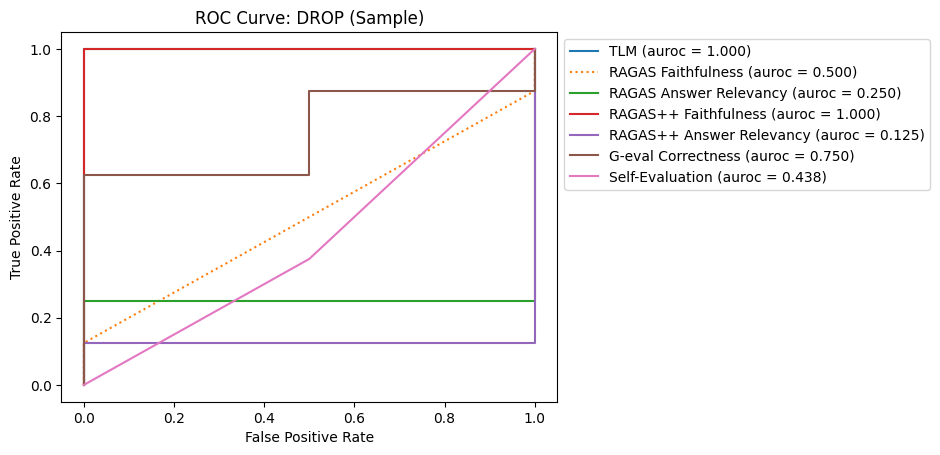

In [25]:
calculate_and_plot_auroc(res_dict[dataset_name], dataset_name+" (Sample)")